In [1]:
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg as linalg
import seaborn as sns
import matplotlib.pyplot as plt
import quantum_sim as qusi

In [2]:
# print the operators
print(qusi.Id(1))
print(qusi.Px(1,0))
print(qusi.Py(1,1))
print(qusi.Pz(1,3))

Id
Px_0
Py_1
Pz_3


In [2]:
# construct a simple product Hamiltonian: H=4(Px_0@2Px_1)
H = qusi.ProductOp([qusi.Px(1,0),qusi.Px(2,1)],4)
print(H)

(8) (Px_0) @ (Px_1)


In [3]:
# the matrix form of the Hamiltonian:
print(H.as_dense_matrix(2))

[[0.+0.j 0.+0.j 0.+0.j 8.+0.j]
 [0.+0.j 0.+0.j 8.+0.j 0.+0.j]
 [0.+0.j 8.+0.j 0.+0.j 0.+0.j]
 [8.+0.j 0.+0.j 0.+0.j 0.+0.j]]


In [39]:
# Hamiltonian for exact dig:
def get_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    H = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in range(N-1)]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in range(N-1)]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in range(N-1)]
                  +[qusi.Pz(h_list[i],i) for i in range(N)])
    return H

#Hamiltonian for Trotter:
"""
EvenBond:   ┌────┐      OddBond:               SingleGate:   ┌────┐
    q0   ---│    │------        -------------             ---│    │----
            │    │                                           └────┘
            │    │                 ┌────┐                    ┌────┐
    q1   ---│    │------        ---│    │----             ---│    │----
            └────┘                 │    │                    └────┘
            ┌────┐                 │    │                    ┌────┐
    q2   ---│    │------        ---│    │----             ---│    │----
            │    │                 └────┘                    └────┘
            │    │                                           ┌────┐
    q3   ---│    │------        -------------             ---│    │----
            └────┘                                           └────┘
"""
def get_trotter_Hamiltonian(N,J,U,h_list):
    assert N==len(h_list)
    evens = []
    odds = []
    for i in range(N):
        if i%2==0:
            evens.append(i)
        else:
            odds.append(i)
    # The even bond hamiltonian
    H0 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in evens]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in evens]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in evens])
    # The odd bond hamiltonian
    H1 = qusi.SumOp([qusi.ProductOp([qusi.Px(1,i),qusi.Px(1,i+1)],-J) for i in odds]
                   +[qusi.ProductOp([qusi.Py(1,i),qusi.Py(1,i+1)],-J) for i in odds]
                  +[qusi.ProductOp([qusi.Pz(1,i),qusi.Pz(1,i+1)],U) for i in odds])
    # The single gates
    H2 = qusi.SumOp([qusi.Pz(h_list[i],i) for i in range(N)])
    return [H0,H1,H2]

def exact_diag(H,T,t_step):
    return linalg.expm((0-1j)*T/t_step*H)

def basic_trotter(H_list,T,t_step,N):
    eH_list = []
    for H in H_list:
        eH_list.append(exact_diag(H.as_sparse_matrix(N),T,t_step))
    return eH_list[2]@eH_list[1]@eH_list[0]

def symmetric_trotter(H_list,T,t_step,N):
    eH_list = [linalg.expm((0-1j)*T/t_step*H_list[0].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[1].as_sparse_matrix(N)),linalg.expm((0-.5j)*T/t_step*H_list[2].as_sparse_matrix(N))]
    return eH_list[2]@eH_list[1]@eH_list[0]@eH_list[1]@eH_list[2]

In [3]:
def get_initial_state(N,s=0):
    if s==0:
        l0 = [1 for i in range(int(N/2))]
        l1 = [0 for i in range(int(N-N/2))]
        return qusi.qstate(l0+l1)
    else:
        return qusi.qstate([i%2 for i in range(N)])

In [36]:
# test the Hamiltonian:
N = 6
J = 1
U = 0
h = 0
#h = 1.5
h_list = [i*h for i in range(N)]

T = 3
t_step = 300
s = 0
#s = 1

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_3168\661156906.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


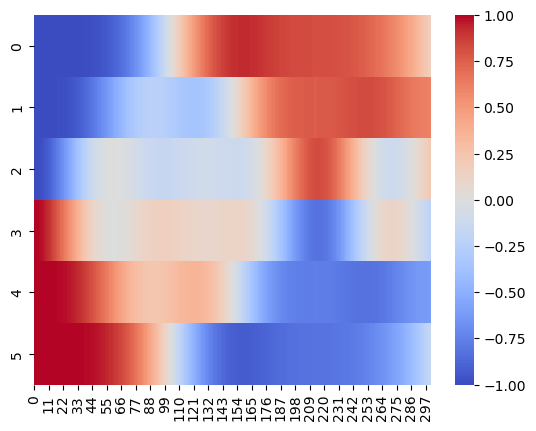

In [37]:
# exact diagonalization:
H = get_Hamiltonian(N,J,U,h_list)
eH = exact_diag(H.as_sparse_matrix(N),T,t_step)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    q.time_evolution(eH)
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_3168\3402603942.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


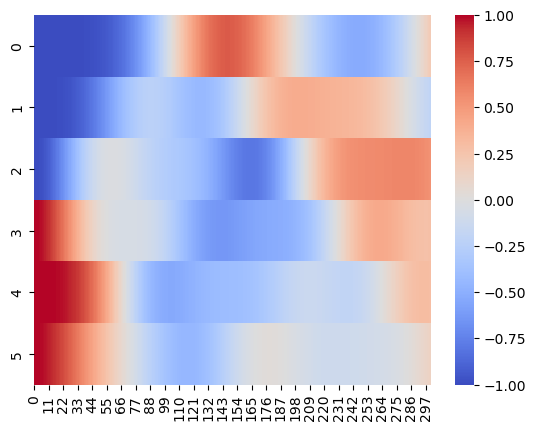

In [38]:
# basic trotter
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = basic_trotter(H_list,T,t_step,N)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    q.time_evolution(eH)
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()

D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
D:\Anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
C:\Users\God_Zao\AppData\Local\Temp\ipykernel_3168\171882786.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  local_mag[i][j+1] = q.local_magnetism(i)


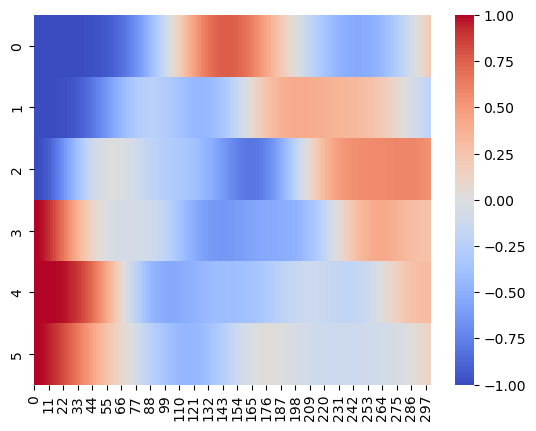

In [40]:
# symetric trotter
H_list = get_trotter_Hamiltonian(N,J,U,h_list)
eH = symmetric_trotter(H_list,T,t_step,N)
q = get_initial_state(N,s)
local_mag = np.zeros([N,t_step+1])

for i in range(N):
    local_mag[i][0] = q.local_magnetism(i)
for j in range(t_step):
    q.time_evolution(eH)
    for i in range(N):
        local_mag[i][j+1] = q.local_magnetism(i)
ax = sns.heatmap(local_mag,annot = False,cmap='coolwarm')
#ax.set_yticks([i*T/t_step for i in range(t_step+1)])
plt.show()